# Binary classification of MRI images
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os, shutil
from pathlib import Path
import random
from sklearn.metrics import roc_curve


In [2]:
def clear_dir(dir_name):
    for filename in os.listdir(dir_name):
        file_path = os.path.join(dir_name, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [3]:
work_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/img/'
model_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/'
step_catalogs = ["10", "20", "30", "40", "50", "60", "70", "80", "90"]

In [4]:
for step_catalog in step_catalogs:
    clear_dir(work_dir + step_catalog)
    clear_dir(model_dir + step_catalog)
    Path(work_dir + step_catalog + "/train/" + "clear").mkdir(parents=True, exist_ok=True)
    Path(work_dir + step_catalog + "/train/" + "artifacts").mkdir(parents=True, exist_ok=True)
    Path(work_dir + step_catalog + "/test/" + "clear").mkdir(parents=True, exist_ok=True)
    Path(work_dir + step_catalog + "/test/" + "artifacts").mkdir(parents=True, exist_ok=True)
    Path(work_dir + step_catalog + "/validation/" + "clear").mkdir(parents=True, exist_ok=True)
    Path(work_dir + step_catalog + "/validation/" + "artifacts").mkdir(parents=True, exist_ok=True)

In [5]:
procentage = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
clear_number = len(os.listdir(work_dir+"clear"))
artifacts_number = len(os.listdir(work_dir+"artifacts"))

procentage_clear = [int(i*clear_number) for i in procentage]
procentage_artifacts = [int(i*artifacts_number) for i in procentage]


In [6]:
procentage_clear, procentage_artifacts

([32, 64, 96, 129, 161, 193, 226, 258, 290],
 [32, 64, 96, 128, 160, 192, 224, 256, 288])

In [7]:
clear_files_index_steps = []
artifacts_files_index_steps = []
for number_of_files in procentage_clear:
    a = random.sample(range(len(os.listdir(work_dir+"clear"))), k=number_of_files)
    clear_files_index_steps.append(a)
for number_of_files in procentage_artifacts:
    a = random.sample(range(len(os.listdir(work_dir+"artifacts"))), k=number_of_files)
    artifacts_files_index_steps.append(a)

In [8]:
for indx, step_catalog in enumerate(step_catalogs):
    for file_index, file_name in enumerate(os.listdir(work_dir + "clear/")):
        if file_index not in clear_files_index_steps[indx]:
            if file_index%2:
                shutil.copy2(work_dir + "clear/" + file_name, work_dir + step_catalog + "/test/" + "clear/")
            else:
                shutil.copy2(work_dir + "clear/" + file_name, work_dir + step_catalog + "/validation/" + "clear/")
        else:
            shutil.copy2(work_dir + "clear/" + file_name, work_dir + step_catalog + "/train/" + "clear/")

for indx, step_catalog in enumerate(step_catalogs):
    for file_index, file_name in enumerate(os.listdir(work_dir+"artifacts/")):
        if file_index not in artifacts_files_index_steps[indx]:
            if file_index%2:
                shutil.copy2(work_dir + "artifacts/" + file_name, work_dir + step_catalog + "/test/" + "artifacts/")
            else:
                shutil.copy2(work_dir + "artifacts/" + file_name, work_dir + step_catalog + "/validation/" + "artifacts/")
        else:
            shutil.copy2(work_dir + "artifacts/" + file_name, work_dir + step_catalog + "/train/" + "artifacts/")

## Data augmentation

In [9]:
gen_parameters = {
    "rotation_range":45,
    "zoom_range":0.25,
    "horizontal_flip":True,
    "vertical_flip":True
}

In [10]:
flow_parameters ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size": 4
}

In [11]:
# create Image generator for training, validation and test set.
data_gen = ImageDataGenerator(**gen_parameters)

In [12]:
train_generators = [
    data_gen.flow_from_directory(
        work_dir + step_catalog + "/train", **flow_parameters)for step_catalog in step_catalogs]

Found 64 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Found 257 images belonging to 2 classes.
Found 321 images belonging to 2 classes.
Found 385 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 578 images belonging to 2 classes.


In [13]:
validation_generators = [
    data_gen.flow_from_directory(
        work_dir + step_catalog + "/validation", **flow_parameters)for step_catalog in step_catalogs]

Found 290 images belonging to 2 classes.
Found 255 images belonging to 2 classes.
Found 225 images belonging to 2 classes.
Found 191 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [14]:
test_generators = [
    data_gen.flow_from_directory(
        work_dir + step_catalog + "/test", **flow_parameters)for step_catalog in step_catalogs]

Found 289 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 226 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 91 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [15]:
class_names = train_generators[0].class_indices
class_names

{'artifacts': 0, 'clear': 1}

## Presentation of images

<IPython.core.display.Javascript object>


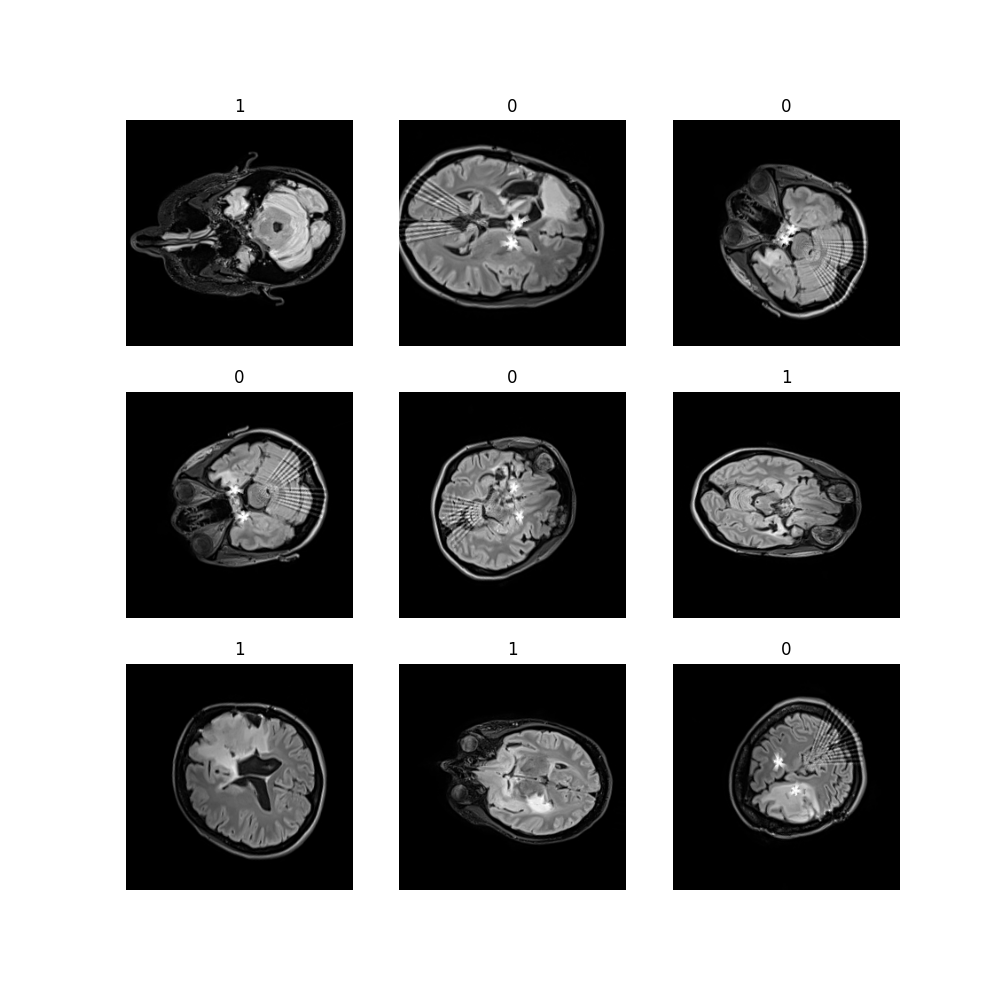

<IPython.core.display.Javascript object>


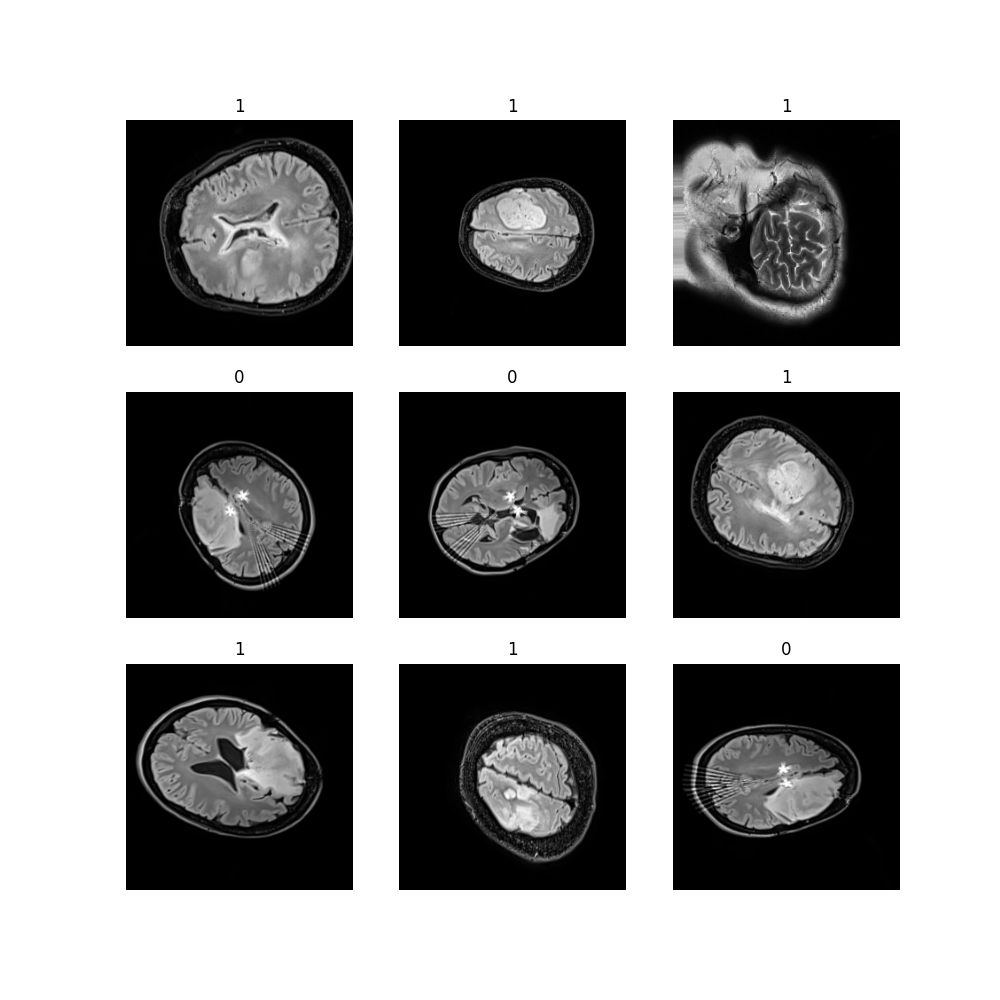

<IPython.core.display.Javascript object>


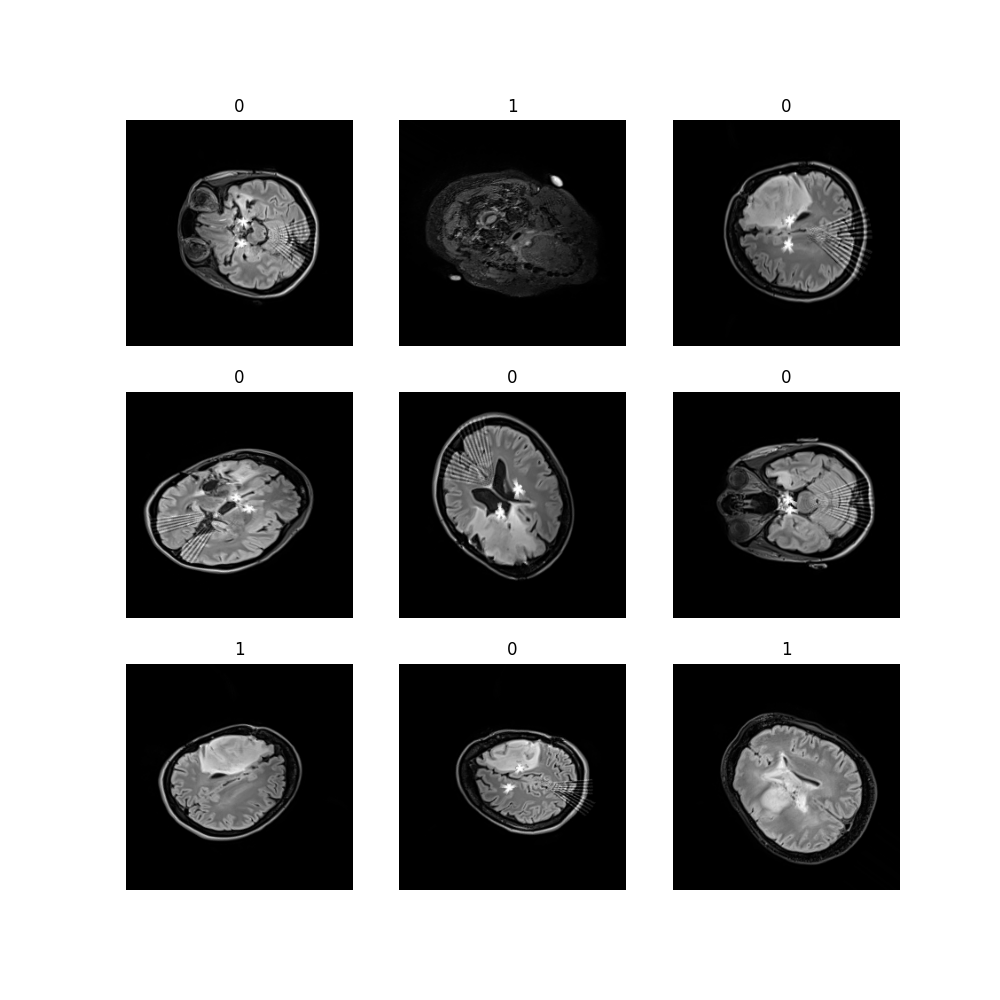

<IPython.core.display.Javascript object>


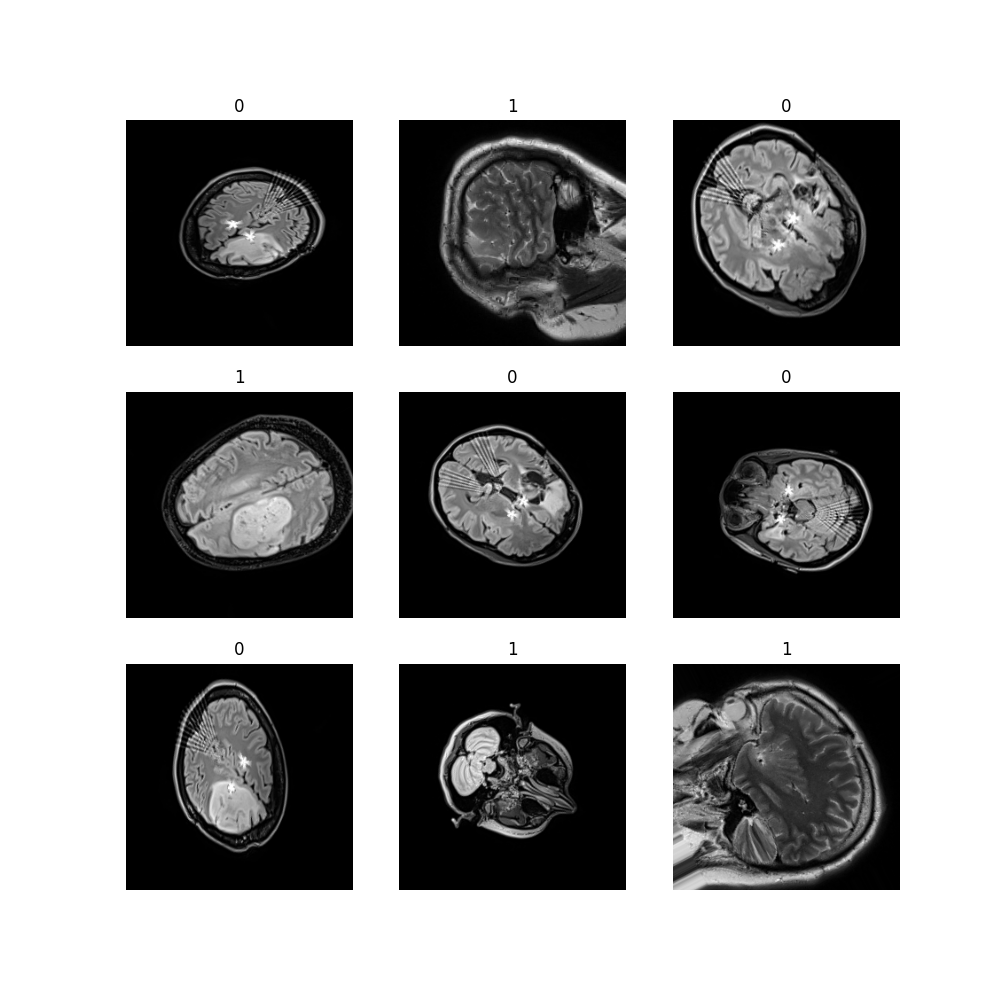

<IPython.core.display.Javascript object>


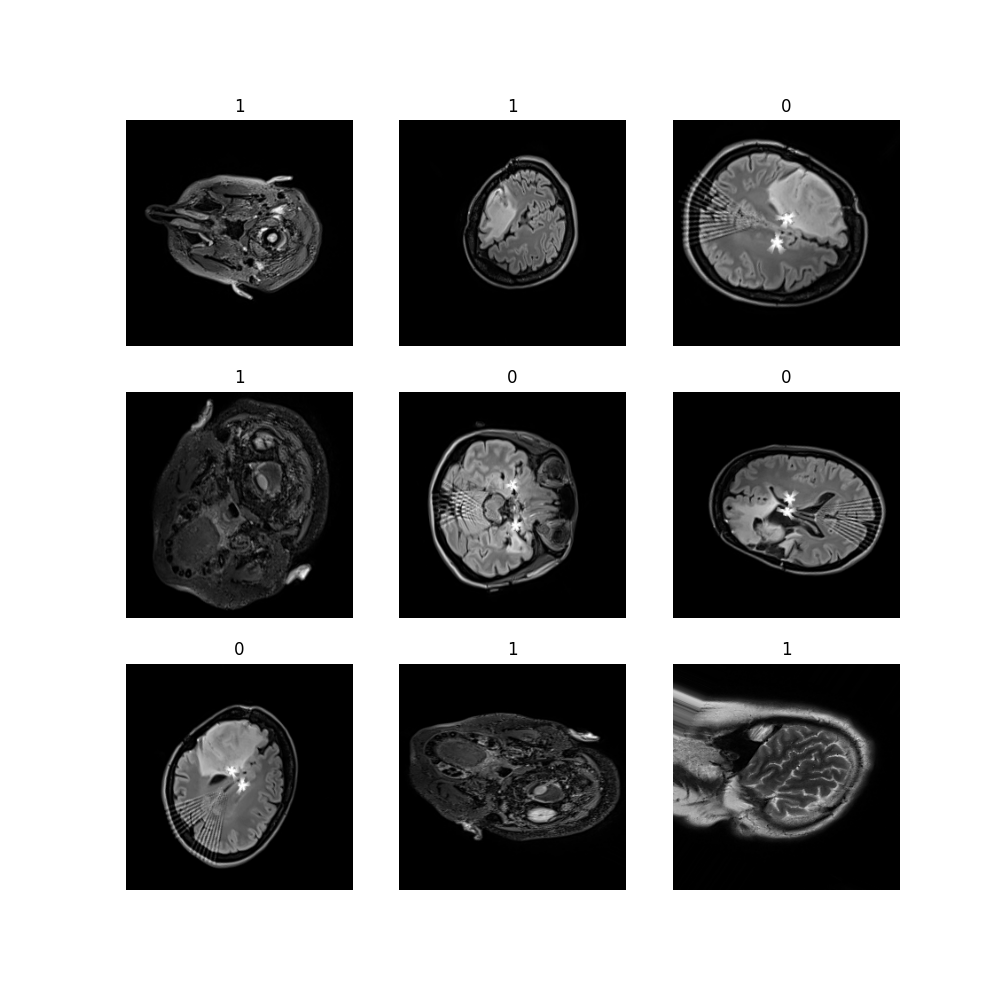

<IPython.core.display.Javascript object>


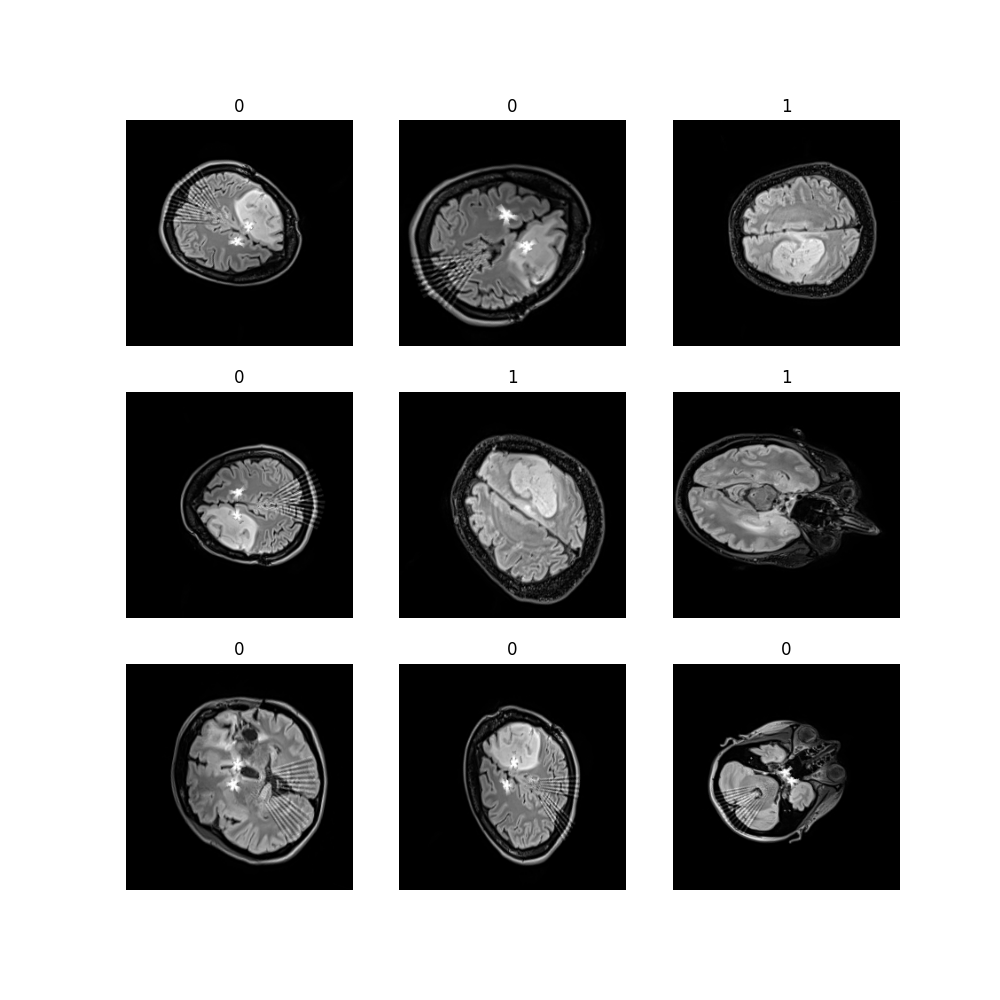

<IPython.core.display.Javascript object>


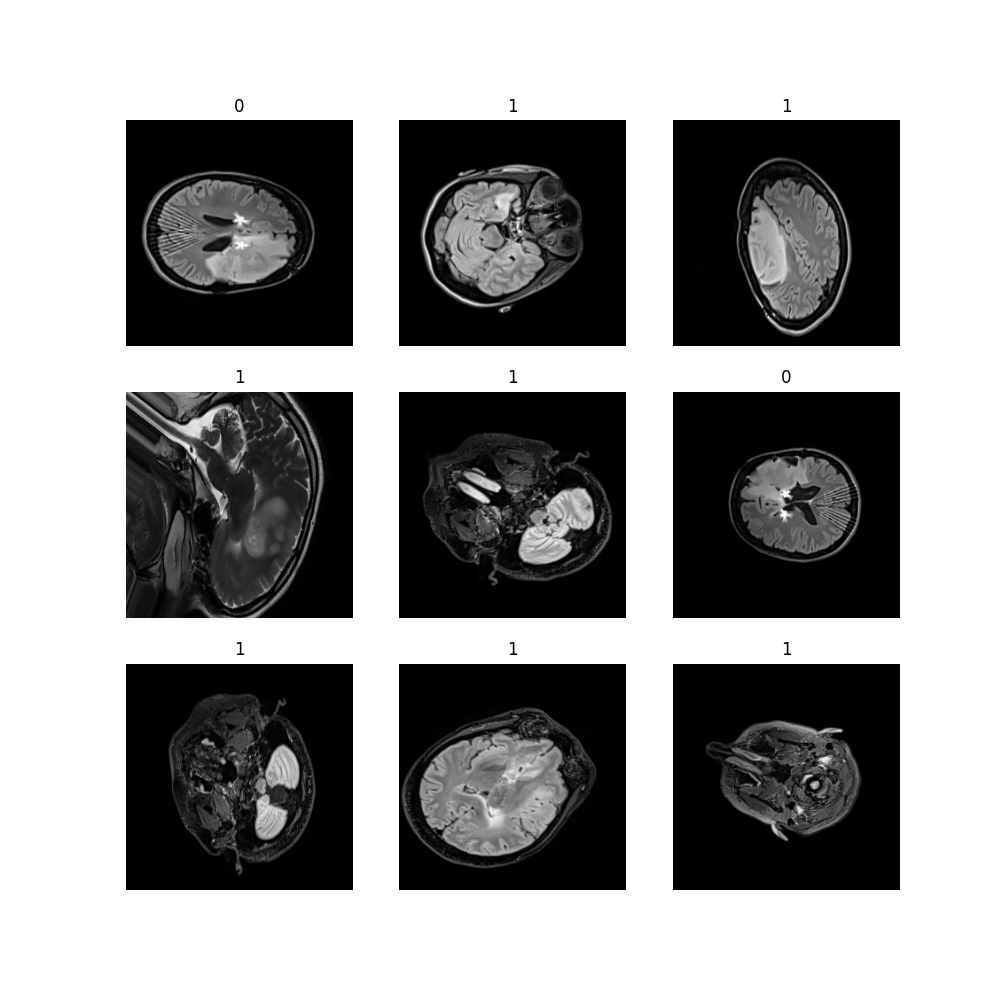

<IPython.core.display.Javascript object>


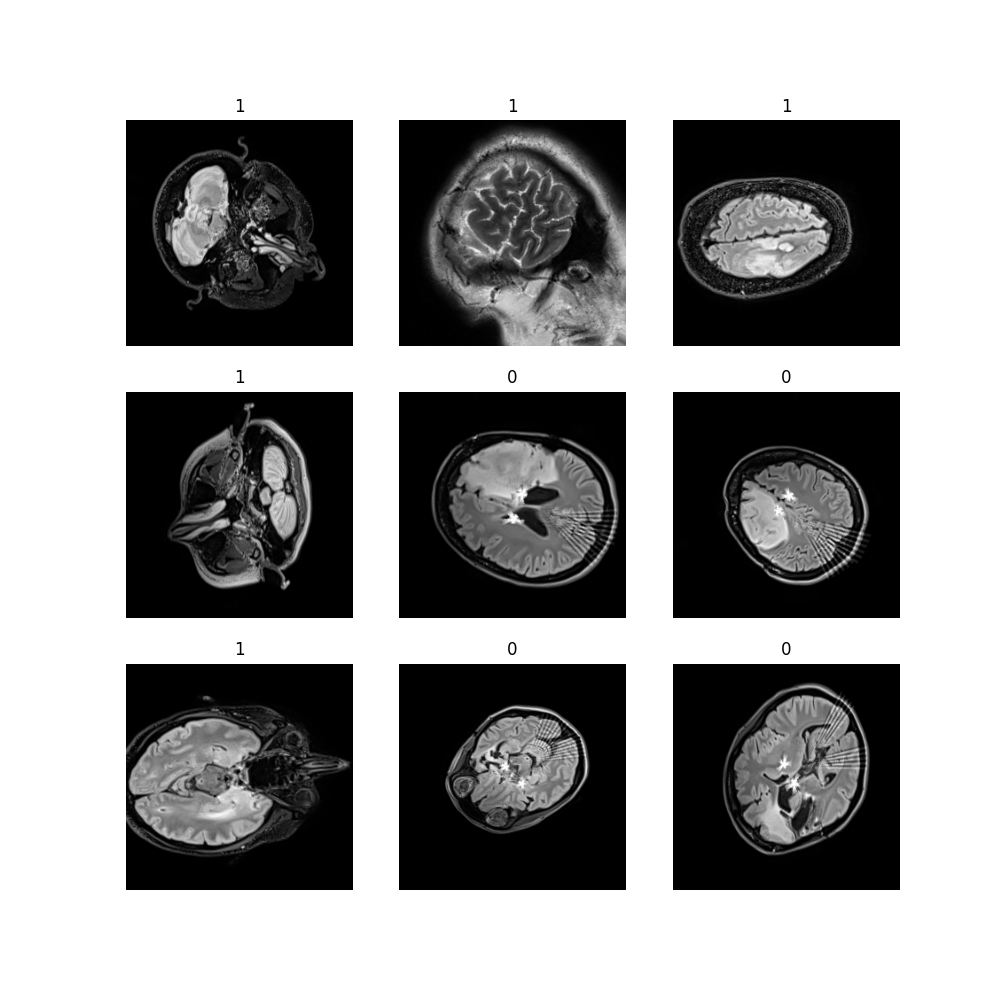

<IPython.core.display.Javascript object>


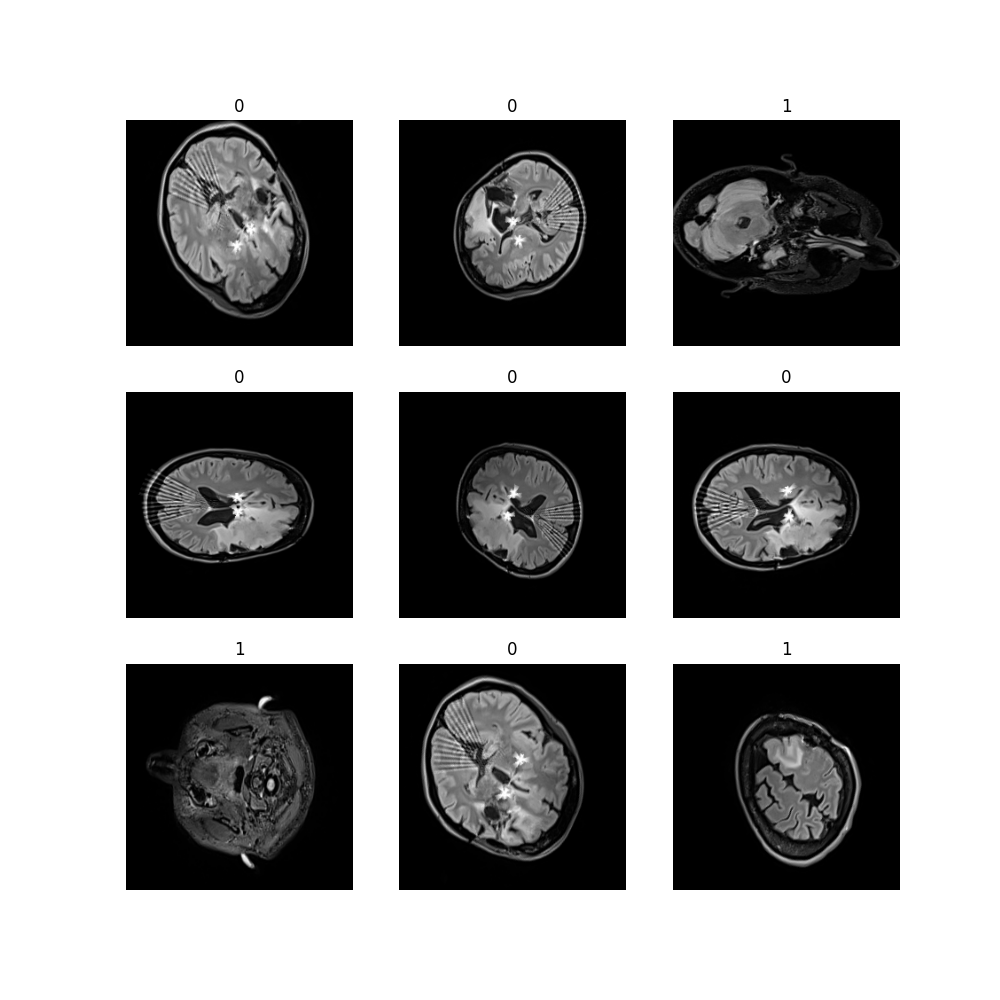

In [16]:
%matplotlib notebook
#plt.figure(figsize=(10, 10))
for gen in train_generators:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        images, labels = gen.next()
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].astype("uint8"), cmap='gray')
        plt.title(int(labels[0]))
        plt.axis("off")

## Build the convolutional neural network

In [17]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR')
]

In [18]:
models = []
history = []
for indx, step_catalog in enumerate(step_catalogs):
model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),


    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir + step_catalog + '/checkpoint',
        save_weights_only=False,
        monitor='val_loss', 
        mode='min', # mam loss wiec min
        save_best_only=True)

    callbacks = [
             EarlyStopping(patience=5),
             model_checkpoint_callback
    ]
    model.compile(optimizer='adam',
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=METRICS)

    hist = model.fit(train_generators[indx], validation_data=validation_generators[indx],
    epochs=60, callbacks=callbacks)

    history.append(hist)
    models.append(model)

Epoch 1/60


C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


16/16 [==============================] - 4s 195ms/step - loss: 0.7085 - accuracy: 0.5469 - val_loss: 0.6817 - val_accuracy: 0.5430
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/10\checkpoint\assets
Epoch 2/60
16/16 [==============================] - 2s 105ms/step - loss: 0.6819 - accuracy: 0.5312 - val_loss: 0.6507 - val_accuracy: 0.6220
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/10\checkpoint\assets
Epoch 3/60
16/16 [==============================] - 2s 103ms/step - loss: 0.5936 - accuracy: 0.6562 - val_loss: 0.6383 - val_accuracy: 0.5876
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/10\checkpoint\assets
Epoch 4/60
16/16 [==============================] - 2s 99ms/step - loss: 0.6217 - accuracy: 0.5938 - val_loss: 0.6433 - val_accuracy: 0.6392
Epoch 5/60
16/16 [==============================] - 2s 105ms/step - loss: 0

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


32/32 [==============================] - 3s 97ms/step - loss: 0.7196 - accuracy: 0.8258 - val_loss: 0.6663 - val_accuracy: 0.5827
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/20\checkpoint\assets
Epoch 2/60
32/32 [==============================] - 2s 51ms/step - loss: 0.6783 - accuracy: 0.5391 - val_loss: 0.6497 - val_accuracy: 0.6929
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/20\checkpoint\assets
Epoch 3/60
32/32 [==============================] - 2s 51ms/step - loss: 0.6653 - accuracy: 0.6406 - val_loss: 0.6042 - val_accuracy: 0.6929
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/20\checkpoint\assets
Epoch 4/60
32/32 [==============================] - 2s 51ms/step - loss: 0.6215 - accuracy: 0.7578 - val_loss: 0.5219 - val_accuracy: 0.7598
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca 

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


48/48 [==============================] - 4s 67ms/step - loss: 0.6849 - accuracy: 0.7915 - val_loss: 0.7476 - val_accuracy: 0.5259
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/30\checkpoint\assets
Epoch 2/60
48/48 [==============================] - 2s 38ms/step - loss: 0.6736 - accuracy: 0.6042 - val_loss: 0.6515 - val_accuracy: 0.6207
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/30\checkpoint\assets
Epoch 3/60
48/48 [==============================] - 2s 37ms/step - loss: 0.6199 - accuracy: 0.6406 - val_loss: 0.5172 - val_accuracy: 0.8147
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/30\checkpoint\assets
Epoch 4/60
48/48 [==============================] - 2s 38ms/step - loss: 0.6018 - accuracy: 0.6719 - val_loss: 0.5206 - val_accuracy: 0.8448
Epoch 5/60
48/48 [==============================] - 2s 37ms/step - loss: 0.420

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


65/65 [==============================] - 4s 56ms/step - loss: 0.7437 - accuracy: 0.7321 - val_loss: 0.6875 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/40\checkpoint\assets
Epoch 2/60
65/65 [==============================] - 2s 29ms/step - loss: 0.6751 - accuracy: 0.6265 - val_loss: 0.6500 - val_accuracy: 0.6947
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/40\checkpoint\assets
Epoch 3/60
65/65 [==============================] - 2s 29ms/step - loss: 0.5970 - accuracy: 0.7082 - val_loss: 0.5471 - val_accuracy: 0.7684
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/40\checkpoint\assets
Epoch 4/60
65/65 [==============================] - 2s 29ms/step - loss: 0.5589 - accuracy: 0.7393 - val_loss: 0.5424 - val_accuracy: 0.6947
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca 

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


81/81 [==============================] - 4s 46ms/step - loss: 0.6911 - accuracy: 0.7319 - val_loss: 0.6472 - val_accuracy: 0.5926
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/50\checkpoint\assets
Epoch 2/60
81/81 [==============================] - 2s 26ms/step - loss: 0.6739 - accuracy: 0.5732 - val_loss: 0.5835 - val_accuracy: 0.7037
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/50\checkpoint\assets
Epoch 3/60
81/81 [==============================] - 2s 25ms/step - loss: 0.6261 - accuracy: 0.6542 - val_loss: 0.5938 - val_accuracy: 0.7963
Epoch 4/60
81/81 [==============================] - 2s 26ms/step - loss: 0.5949 - accuracy: 0.6916 - val_loss: 0.5210 - val_accuracy: 0.7963
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/50\checkpoint\assets
Epoch 5/60
81/81 [==============================] - 2s 26ms/step - loss: 0.463

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


97/97 [==============================] - 5s 48ms/step - loss: 0.6982 - accuracy: 0.6691 - val_loss: 0.6619 - val_accuracy: 0.5500
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/60\checkpoint\assets
Epoch 2/60
97/97 [==============================] - 3s 26ms/step - loss: 0.6141 - accuracy: 0.6571 - val_loss: 0.5256 - val_accuracy: 0.8214
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/60\checkpoint\assets
Epoch 3/60
97/97 [==============================] - 3s 26ms/step - loss: 0.4900 - accuracy: 0.7662 - val_loss: 0.2814 - val_accuracy: 0.9143
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/60\checkpoint\assets
Epoch 4/60
97/97 [==============================] - 2s 25ms/step - loss: 0.2657 - accuracy: 0.8961 - val_loss: 0.1743 - val_accuracy: 0.9286
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca 

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


113/113 [==============================] - 5s 40ms/step - loss: 0.6793 - accuracy: 0.6441 - val_loss: 0.6406 - val_accuracy: 0.5773
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/70\checkpoint\assets
Epoch 2/60
113/113 [==============================] - 2s 20ms/step - loss: 0.5886 - accuracy: 0.6978 - val_loss: 0.6947 - val_accuracy: 0.6186
Epoch 3/60
113/113 [==============================] - 3s 22ms/step - loss: 0.4417 - accuracy: 0.7911 - val_loss: 0.2080 - val_accuracy: 0.9278
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/70\checkpoint\assets
Epoch 4/60
113/113 [==============================] - 2s 21ms/step - loss: 0.1642 - accuracy: 0.9400 - val_loss: 0.1865 - val_accuracy: 0.9278
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/70\checkpoint\assets
Epoch 5/60
113/113 [==============================] - 2s 22ms/step - l

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


129/129 [==============================] - 5s 37ms/step - loss: 0.6895 - accuracy: 0.6318 - val_loss: 0.6303 - val_accuracy: 0.6094
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/80\checkpoint\assets
Epoch 2/60
129/129 [==============================] - 2s 19ms/step - loss: 0.6287 - accuracy: 0.6518 - val_loss: 0.5229 - val_accuracy: 0.7812
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/80\checkpoint\assets
Epoch 3/60
129/129 [==============================] - 2s 19ms/step - loss: 0.4108 - accuracy: 0.8288 - val_loss: 0.3901 - val_accuracy: 0.8281
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/80\checkpoint\assets
Epoch 4/60
129/129 [==============================] - 2s 19ms/step - loss: 0.2806 - accuracy: 0.8949 - val_loss: 0.0830 - val_accuracy: 0.9688
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflo

C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


145/145 [==============================] - 5s 34ms/step - loss: 0.6678 - accuracy: 0.6526 - val_loss: 0.5032 - val_accuracy: 0.7647
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/90\checkpoint\assets
Epoch 2/60
145/145 [==============================] - 3s 18ms/step - loss: 0.4243 - accuracy: 0.8149 - val_loss: 0.2320 - val_accuracy: 0.8824
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/90\checkpoint\assets
Epoch 3/60
145/145 [==============================] - 3s 18ms/step - loss: 0.1495 - accuracy: 0.9429 - val_loss: 0.1424 - val_accuracy: 0.9706
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_1/90\checkpoint\assets
Epoch 4/60
145/145 [==============================] - 3s 20ms/step - loss: 0.0575 - accuracy: 0.9827 - val_loss: 0.0018 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflo

##  Visualize a deep learning model 

In [19]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, None, None, None)  0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, None, None, 32)   

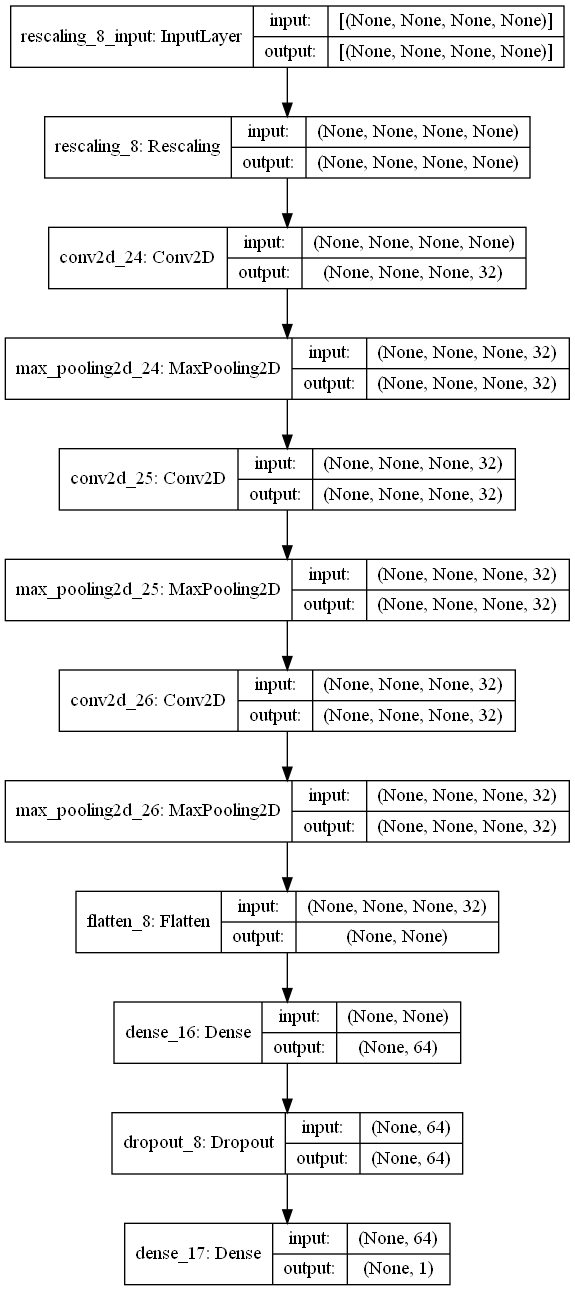

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file=model_dir+ "/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the model’s performance


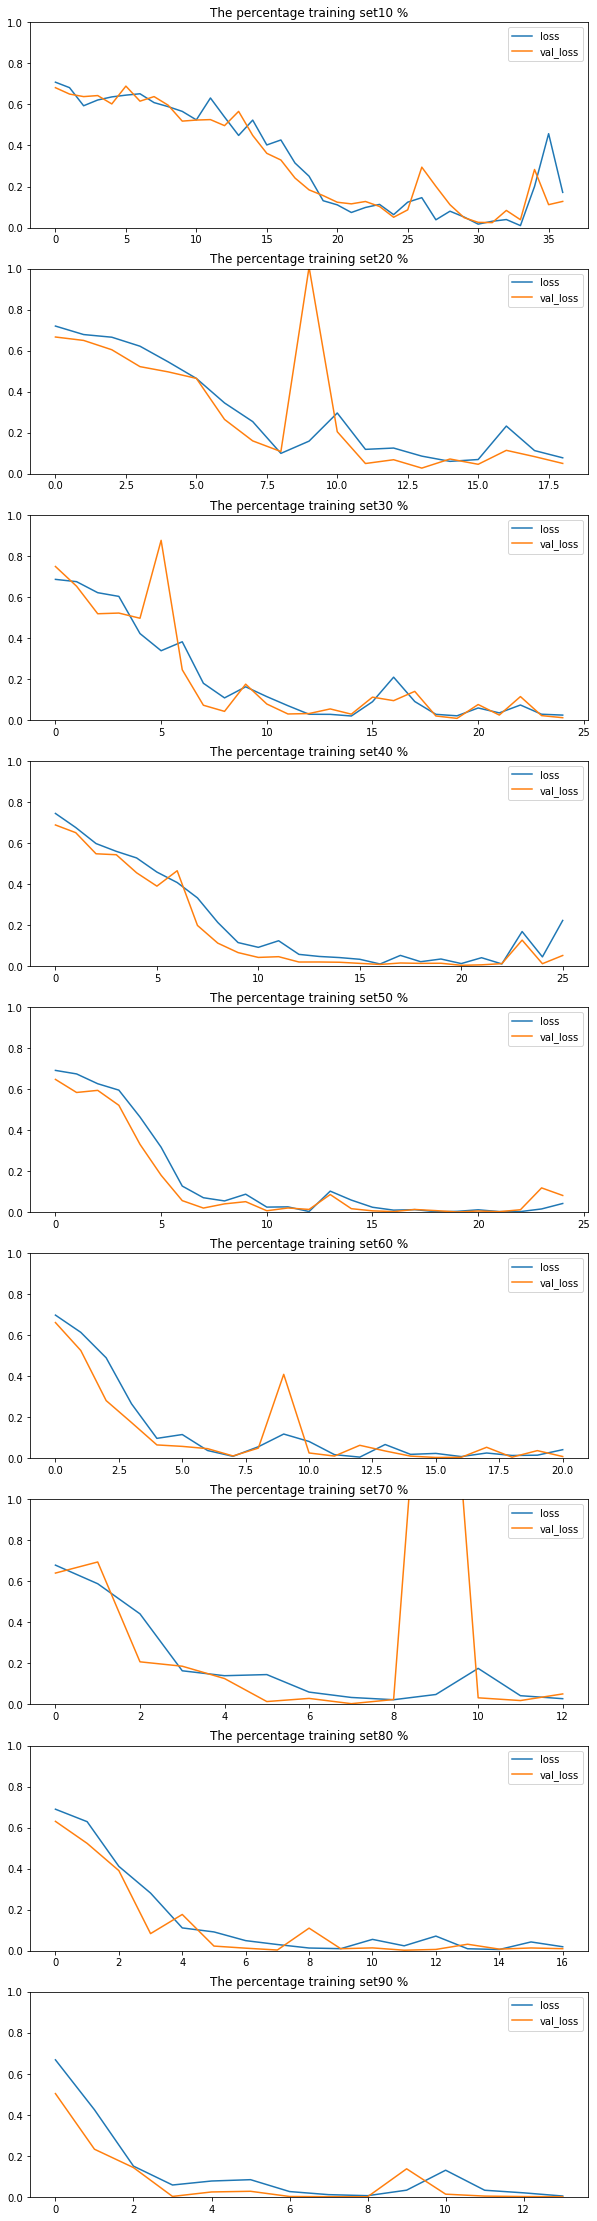

In [21]:
plt.figure(figsize=(10, 40))
for indx, hist in enumerate(history):
    metrics_df = pd.DataFrame(hist.history)
    ax = plt.subplot(9, 1, indx + 1)
    ax.set(ylim =(0, 1.0))
    plt.plot(metrics_df[["loss","val_loss"]])
    plt.legend(["loss","val_loss"])
    plt.title("The percentage training set{} %".format(step_catalogs[indx]))


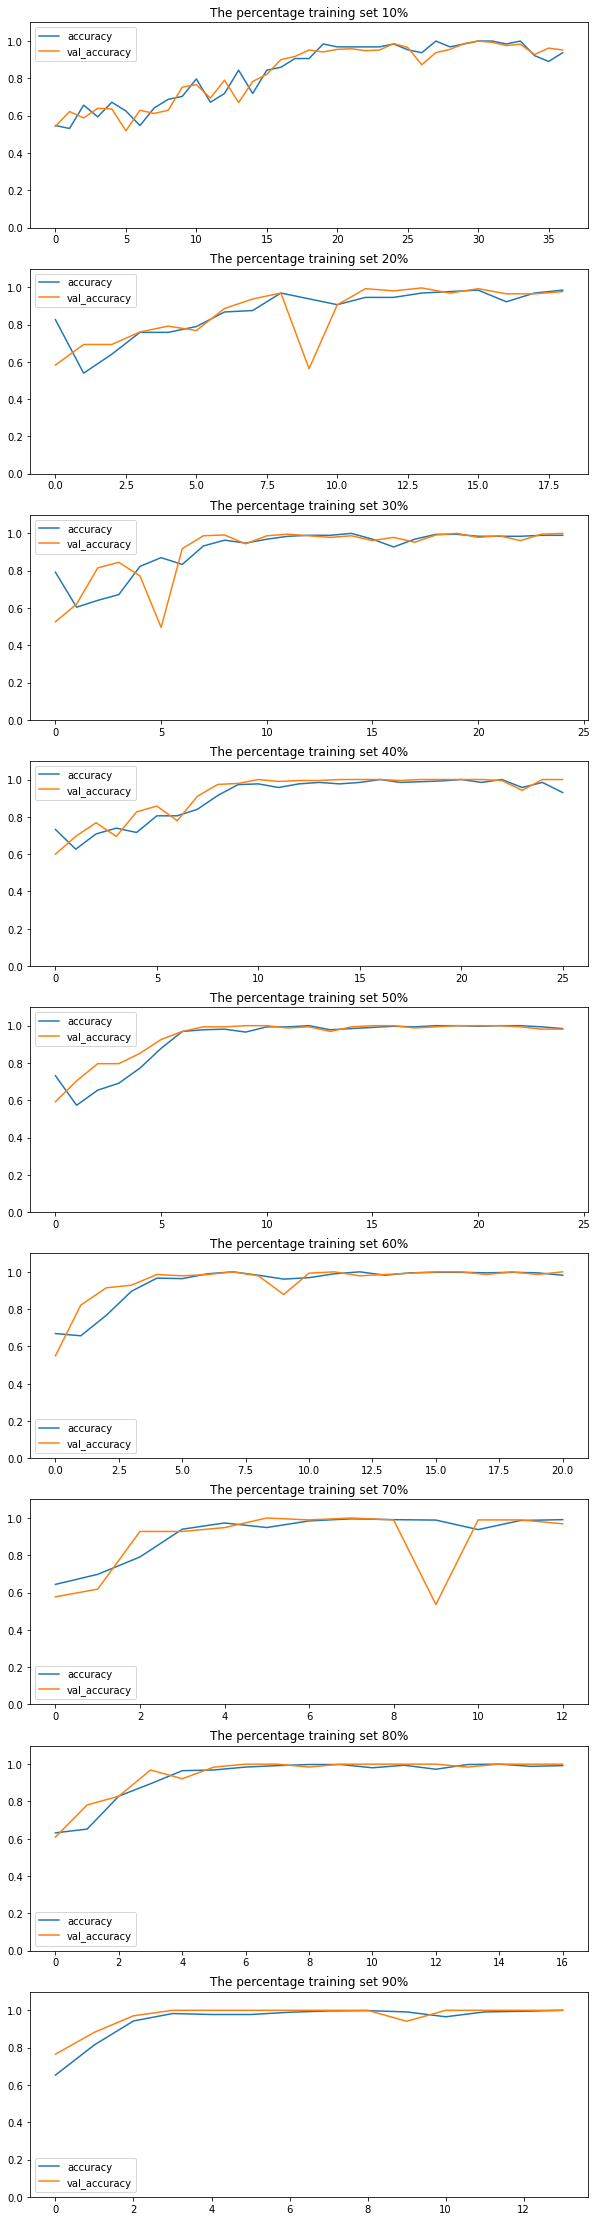

In [22]:
plt.figure(figsize=(10, 40))
for indx, hist in enumerate(history):
    metrics_df = pd.DataFrame(hist.history)
    ax = plt.subplot(9, 1, indx + 1)
    ax.set(ylim =(0, 1.1))
    plt.plot(metrics_df[["accuracy","val_accuracy"]])
    plt.legend(["accuracy","val_accuracy"])
    plt.title("The percentage training set {}%".format(step_catalogs[indx]))


In [23]:
#metrics_df[["loss","val_loss"]].plot();

In [24]:
#metrics_df[["accuracy","val_accuracy"]].plot();

In [25]:
#metrics_df[["tn","fn", "val_tn", "val_fn"]].plot();

In [26]:
#metrics_df[["tp","fp", "val_tp", "val_fp"]].plot();

In [27]:
#metrics_df[["recall","precision"]].plot();

In [28]:
#metrics_df[["val_recall", "val_precision"]].plot();

In [29]:
#metrics_df[["auc", "val_auc"]].plot();

In [30]:
#metrics_df[["prc", "val_prc"]].plot();

## Checking the performance of the model on the validation set.

In [31]:
val_results = []
for indx, model in enumerate(models):
    res = model.evaluate(validation_generators[indx])
    val_results.append(res)

9/9 [==============================] - 0s 15ms/step - loss: 5.3146e-04 - accuracy: 1.0000


## Checking the model on the test set.

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = []
for indx, model in enumerate(models):
    res = model.evaluate(test_generators[indx])
    test_results.append(res)

Evaluate on test data
8/8 [==============================] - 0s 29ms/step - loss: 5.8093e-04 - accuracy: 1.0000


The percentage training set 10 True positive: 182 True negative: 198 False Positive: 0 False negative: 20

The percentage training set 20 True positive: 203 True negative: 188 False Positive: 2 False negative: 7

The percentage training set 30 True positive: 218 True negative: 181 False Positive: 0 False negative: 1

The percentage training set 40 True positive: 205 True negative: 195 False Positive: 0 False negative: 0

The percentage training set 50 True positive: 211 True negative: 188 False Positive: 0 False negative: 1

The percentage training set 60 True positive: 190 True negative: 210 False Positive: 0 False negative: 0

The percentage training set 70 True positive: 186 True negative: 210 False Positive: 0 False negative: 4

The percentage training set 80 True positive: 202 True negative: 197 False Positive: 0 False negative: 1

The percentage training set 90 True positive: 211 True negative: 189 False Positive: 0 False negative: 0



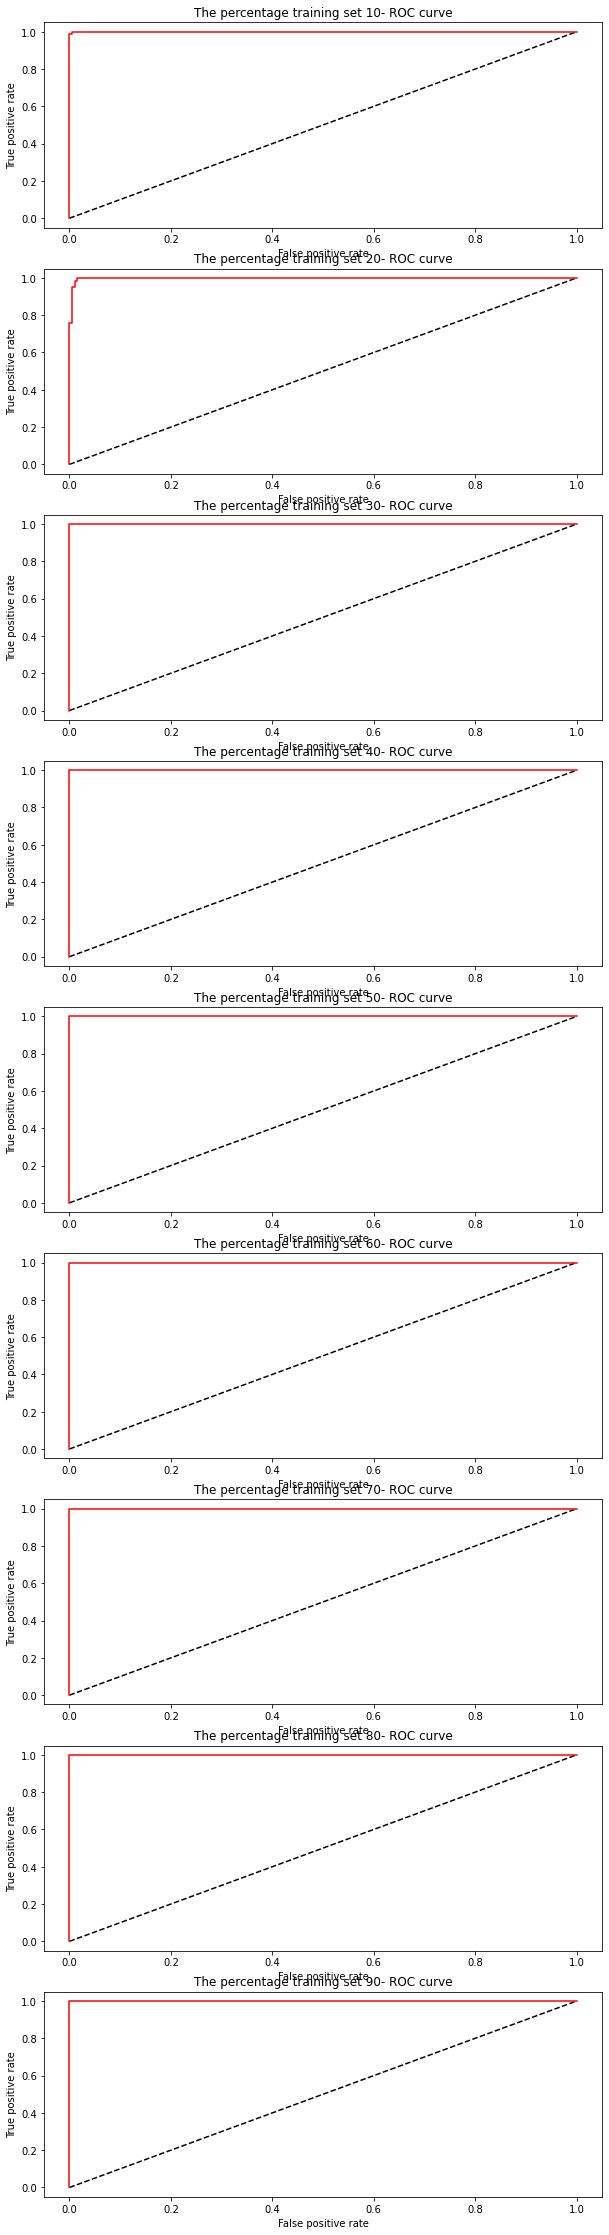

In [33]:
plt.figure(figsize=(10, 40))
for indx, model in enumerate(models):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    threshold = 0.5
    y_predict = []
    y_true = []

    for _ in range(400):
        images, labels = test_generators[indx].next()
        class_info = int(labels[0])

        test_image_orginal = np.expand_dims(images[0].astype("uint8"), axis=0)
        prediction = model.predict(test_image_orginal)[0][0]
        y_predict.append(prediction)
        y_true.append(int(labels[0]))
    #     print(class_info, prediction)
    #     plt.imshow(images[0].astype("uint8"), cmap='gray')
    #     plt.show()


        if prediction >= threshold:
            if class_info == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if class_info == 0:
                tn = tn + 1
            else:
                fn = fn + 1
    print("The percentage training set {} True positive: {} True negative: {} False Positive: {} False negative: {}\n".format(step_catalogs[indx], tp, tn, fp, fn))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predict)
    ax = plt.subplot(9, 1, indx + 1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, 'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('The percentage training set {}- ROC curve'.format(step_catalogs[indx]))
plt.show()

In [40]:
path = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/train_set/'

In [41]:
test_2 = data_gen.flow_from_directory(path, **flow_parameters)

Found 1607 images belonging to 2 classes.


The percentage training set 10 True positive: 1725 True negative: 2063 False Positive: 0 False negative: 212

The percentage training set 20 True positive: 1844 True negative: 2017 False Positive: 4 False negative: 135

The percentage training set 30 True positive: 1887 True negative: 2057 False Positive: 1 False negative: 55

The percentage training set 40 True positive: 1930 True negative: 2066 False Positive: 0 False negative: 4

The percentage training set 50 True positive: 1869 True negative: 2053 False Positive: 1 False negative: 77

The percentage training set 60 True positive: 1854 True negative: 2099 False Positive: 9 False negative: 38

The percentage training set 70 True positive: 1908 True negative: 2036 False Positive: 4 False negative: 52

The percentage training set 80 True positive: 1884 True negative: 2061 False Positive: 0 False negative: 55

The percentage training set 90 True positive: 1907 True negative: 2069 False Positive: 2 False negative: 22



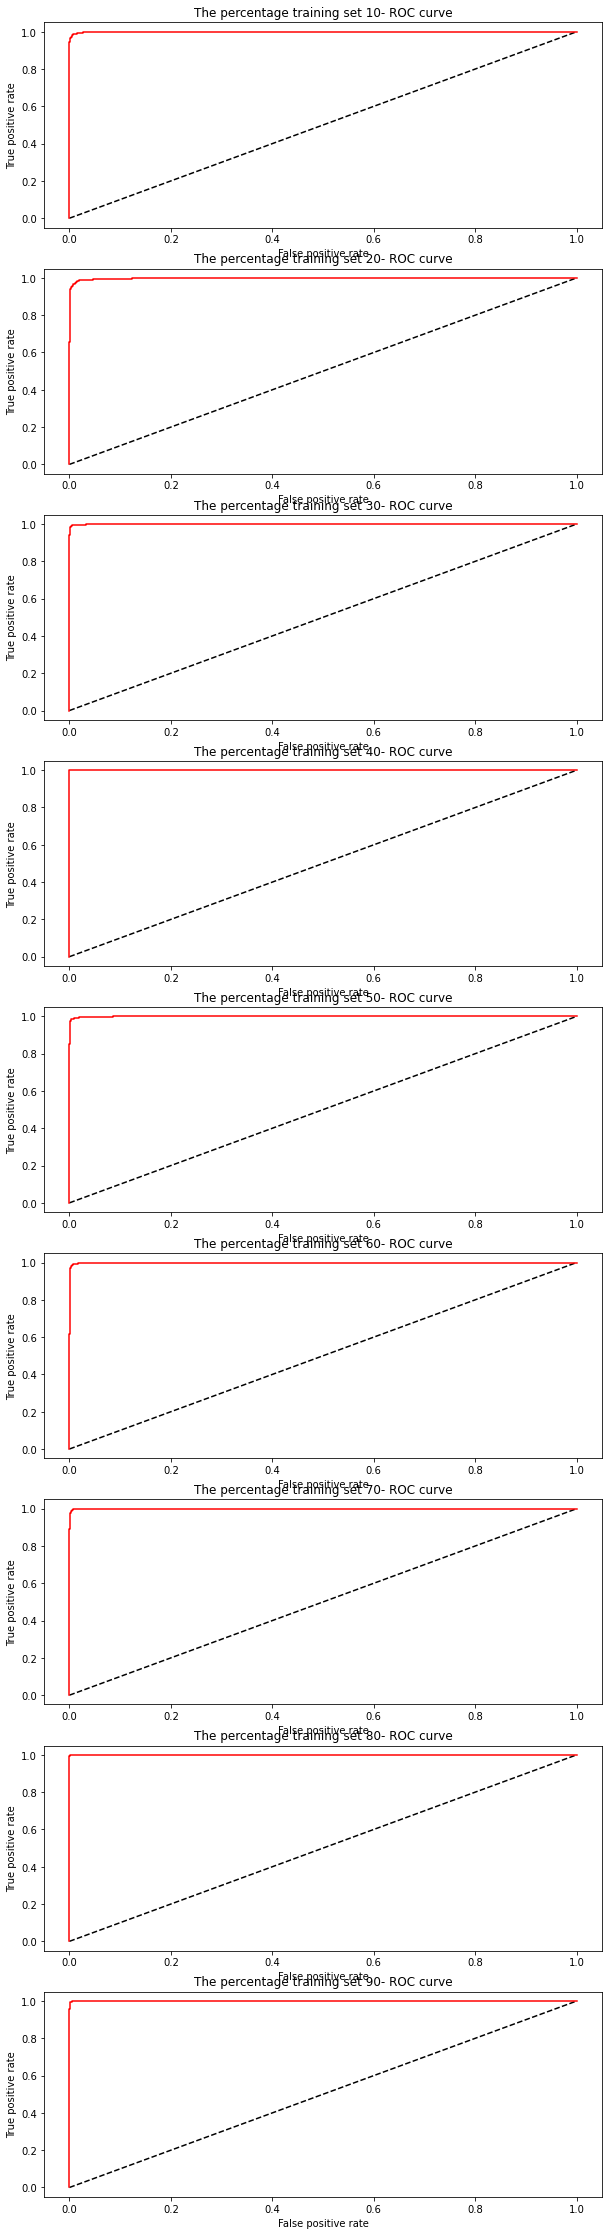

In [42]:
plt.figure(figsize=(10, 40))
for indx, model in enumerate(models):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    threshold = 0.5
    y_predict = []
    y_true = []

    for _ in range(4000):
        images, labels = test_2.next()
        class_info = int(labels[0])

        test_image_orginal = np.expand_dims(images[0].astype("uint8"), axis=0)
        prediction = model.predict(test_image_orginal)[0][0]
        y_predict.append(prediction)
        y_true.append(int(labels[0]))
    #     print(class_info, prediction)
    #     plt.imshow(images[0].astype("uint8"), cmap='gray')
    #     plt.show()


        if prediction >= threshold:
            if class_info == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if class_info == 0:
                tn = tn + 1
            else:
                fn = fn + 1
    print("The percentage training set {} True positive: {} True negative: {} False Positive: {} False negative: {}\n".format(step_catalogs[indx], tp, tn, fp, fn))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predict)
    ax = plt.subplot(9, 1, indx + 1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, 'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('The percentage training set {}- ROC curve'.format(step_catalogs[indx]))
plt.show()

In [46]:
path = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/img/test_1/'

In [47]:
test_3 = data_gen.flow_from_directory(path, **flow_parameters)

Found 217 images belonging to 2 classes.


The percentage training set 10 True positive: 186 True negative: 106 False Positive: 0 False negative: 8

The percentage training set 20 True positive: 168 True negative: 122 False Positive: 3 False negative: 7

The percentage training set 30 True positive: 194 True negative: 105 False Positive: 1 False negative: 0

The percentage training set 40 True positive: 192 True negative: 106 False Positive: 2 False negative: 0

The percentage training set 50 True positive: 175 True negative: 99 False Positive: 26 False negative: 0

The percentage training set 60 True positive: 201 True negative: 45 False Positive: 54 False negative: 0

The percentage training set 70 True positive: 190 True negative: 107 False Positive: 3 False negative: 0

The percentage training set 80 True positive: 187 True negative: 110 False Positive: 1 False negative: 2

The percentage training set 90 True positive: 188 True negative: 9 False Positive: 103 False negative: 0



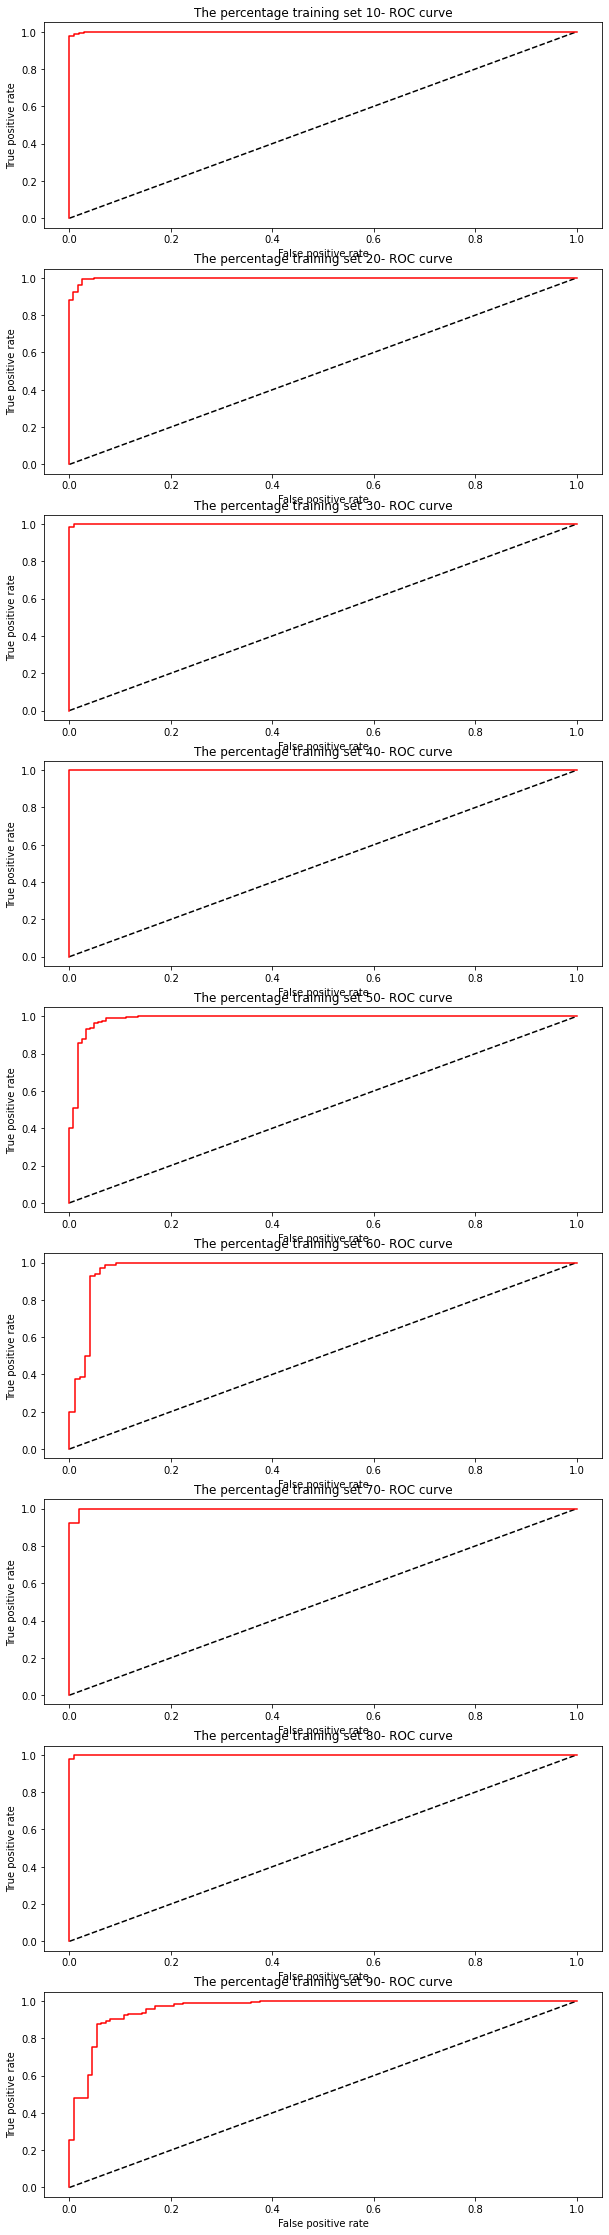

In [49]:
plt.figure(figsize=(10, 40))
for indx, model in enumerate(models):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    threshold = 0.5
    y_predict = []
    y_true = []

    for _ in range(300):
        images, labels = test_3.next()
        class_info = int(labels[0])

        test_image_orginal = np.expand_dims(images[0].astype("uint8"), axis=0)
        prediction = model.predict(test_image_orginal)[0][0]
        y_predict.append(prediction)
        y_true.append(int(labels[0]))
    #     print(class_info, prediction)
    #     plt.imshow(images[0].astype("uint8"), cmap='gray')
    #     plt.show()


        if prediction >= threshold:
            if class_info == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if class_info == 0:
                tn = tn + 1
            else:
                fn = fn + 1
    print("The percentage training set {} True positive: {} True negative: {} False Positive: {} False negative: {}\n".format(step_catalogs[indx], tp, tn, fp, fn))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predict)
    ax = plt.subplot(9, 1, indx + 1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, 'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('The percentage training set {}- ROC curve'.format(step_catalogs[indx]))
plt.show()